In [1497]:
import networkx as nx
from matplotlib import pyplot as plt
import random
from IPython.display import clear_output
import time
import math

In [1498]:
plt_options = {
  "node_size": 350,
  "node_color": "white",
  "edgecolors": "black",
  "with_labels": True,
  "font_size": 8
}

agent_path_draw_delay = 1

In [1499]:
def setup_road(n_edges_to_remove, m = 5, n = 5):
  G = nx.grid_2d_graph(m, n)

  available_edges = list(G.edges)

  max_edges_to_remove = len(list(G.edges)) - len(list(G.nodes)) + 1

  i = 0

  while i < n_edges_to_remove and i < max_edges_to_remove:
    selected_edge = random.choice(available_edges)
    G.remove_edge(*selected_edge)

    if not nx.is_connected(G):
      G.add_edge(*selected_edge)
    else:
      i += 1

    available_edges.remove(selected_edge)

  return G

In [1500]:
def draw_agent_path(path, road, current_crossroads, visited_crossroads):
    edges = [(path[i], path[i+1]) for i in range(len(path) - 1)]
    edge_labels = {edge: i + 1 for i, edge in enumerate(edges)}

    pos = {(x,y):(y,-x) for x,y in road.nodes()}

    path_node_color = ['red' if node == current_crossroads else 'yellowgreen' for node in path]
    visited_crossroads_node_color = ['gray' if node in visited_crossroads else 'white' for node in road.nodes]

    plt.figure(figsize=(5,5))
    nx.draw(road, pos=pos, **{ **plt_options, 'node_color': visited_crossroads_node_color })
    nx.draw_networkx_nodes(road, nodelist=path, pos=pos, node_color=path_node_color)
    nx.draw_networkx_edges(road, edgelist=edges, pos=pos, edge_color='yellowgreen')
    nx.draw_networkx_edge_labels(road, edge_labels=edge_labels, pos=pos)
    plt.show()

In [1501]:
class KnowledgeBase:
  def __init__(self):
    self.available_paths = {}
    self.visited_crossroads = []

  def update(self, crossroads, neighbords):
    self.visited_crossroads.append(crossroads)
    self.available_paths = {**self.available_paths, crossroads: neighbords}

  def get_unvisited(self, crossroads_list): 
    unvisited_crossroads = []

    for crossroads in crossroads_list:
      if crossroads not in self.visited_crossroads:
        unvisited_crossroads.append(crossroads)
    
    return unvisited_crossroads
  
  def calculate_distance(self, crossroads_a, crossroads_b):
    destY, destX = crossroads_b
    depY, depX = crossroads_a

    return math.sqrt((destX - depX)**2 + (destY - depY)**2)
  
  def suggent_next_move(self, current_crossroads, dest):
    available_crossroads = self.available_paths[current_crossroads]

    unvisited_crossroads = self.get_unvisited(available_crossroads)

    min_distance = float('inf')

    next_crossroads = None

    for crossroads in unvisited_crossroads:
      unvisited_neighbors = self.get_unvisited(available_crossroads[crossroads])

      if crossroads == dest:
        return crossroads

      if not unvisited_neighbors:
        continue

      distances = map(lambda item: self.calculate_distance(item, dest), unvisited_neighbors)

      local_min_distance = min(list(distances))

      if local_min_distance < min_distance:
        min_distance = local_min_distance
        next_crossroads = crossroads

    return next_crossroads

In [1502]:
class Agent:
  def __init__(self, road: nx.Graph, knowledge_base: KnowledgeBase):
    self.road = road
    self.knowledge_base = knowledge_base
    self.current_crossroads = None
    self.moves_count = 0

  def tell(self, current_crossroads):
    available_paths = {}

    for neighbor in self.road.neighbors(current_crossroads):
      available_paths[neighbor] = list(self.road.neighbors(neighbor))
    
    self.knowledge_base.update(current_crossroads, available_paths)

  def ask(self, dest):
    return self.knowledge_base.suggent_next_move(self.current_crossroads, dest)

  def act(self, next_crossroads, stack):
    if next_crossroads:
      print(f"#{self.moves_count} Move: {next_crossroads}")
      
      stack.append(next_crossroads)
    else:
      stack.pop()

      if stack:
        print(f"#{self.moves_count} 🔴 Dead end! Move back to {stack[-1]}")

    if stack:
      self.current_crossroads = stack[-1]

  def drive(self, dep, dest):
    stack = [dep]

    self.current_crossroads = dep

    self.moves_count = 0

    while self.current_crossroads != dest and stack:
      self.moves_count += 1

      self.tell(self.current_crossroads)
      next_crossroads = self.ask(dest)
      self.act(next_crossroads, stack)

      draw_agent_path(stack, self.road, self.current_crossroads, self.knowledge_base.visited_crossroads)
      time.sleep(agent_path_draw_delay)
      clear_output(wait=True)

    if stack:
      print(f"🟢 Stop! Path is found: {stack}")
    else:
      print("❌ Path wasn't found!")

    draw_agent_path(stack, self.road, self.current_crossroads, self.knowledge_base.visited_crossroads)
      
    return stack

🟢 Stop! Path is found: [(2, 2), (1, 2), (1, 3), (2, 3), (3, 3), (4, 3), (4, 4)]


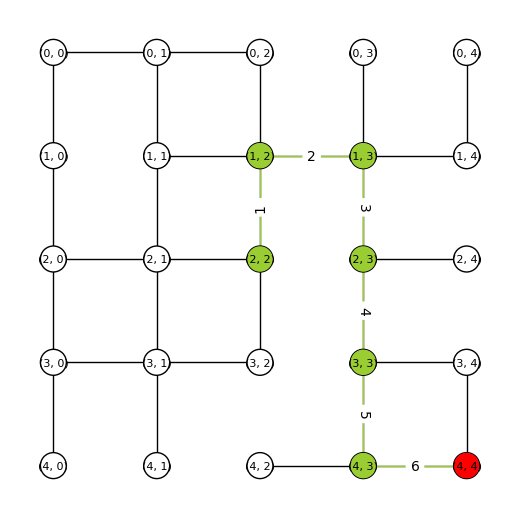

In [1503]:
road = setup_road(n_edges_to_remove=10)
knowledge_base = KnowledgeBase()
agent = Agent(road, knowledge_base)

path = agent.drive((2, 2), (4, 4))

**Висновок**: виконавши дану лабораторну роботу, було отримано навички роботи з інтелектуальними агентами. Розроблено раціонального інтелектуального агента, що враховує мету - доїхати з початкової точки в точку призначення по граф-дорозі, розробленій в попередній лабораторній роботі. Також було реалізовано механізм відображення стану шляху агента після кожного пересування по дорозі.